# Import Dependencies

In [88]:
import tensorflow as tf
from keras.layers import Conv2D,Dropout,MaxPooling2D,Concatenate,Conv2DTranspose,Input,Lambda,UpSampling2D
import random
import numpy as np
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import matplotlib
import os
import pandas as pd

# Define Training Path and Some Parameters

In [6]:
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

In [7]:
img_width=128
img_height=128
img_channels=3

In [8]:
train_ids=next(os.walk(TRAIN_PATH))[1]
test_ids=next(os.walk(TEST_PATH))[1]

# Resizing Training Images and Masks

In [9]:
#create arrays full of zeros with shapes similar to training sets 
X_train=np.zeros((len(train_ids),img_height,img_width,img_channels),dtype=np.uint8) 
Y_train=np.zeros((len(train_ids),img_height,img_width,1),dtype=np.bool_) #the y value is boolean

In [10]:
Y_train.shape

(670, 128, 128, 1)

In [11]:
X_train.shape

(670, 128, 128, 3)

In [12]:
#resizing training images and masks
for n,id_ in enumerate(train_ids):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:img_channels]  
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask=np.zeros((img_height,img_width,1),dtype=np.bool_)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_=imread(path+'/masks/'+mask_file) #read each mask
        mask_=np.expand_dims(resize(mask_,(img_height,img_width),mode='constant',preserve_range=True),axis=-1) #expand dims of mask
        mask= np.maximum(mask,mask_) # for each pixel in picture compare it with the mask and select the max
    Y_train[n]=mask

In [13]:
#resizing test images 
X_test=np.zeros((len(test_ids),img_height,img_width,img_channels),dtype=np.uint8)
sizes_test=[]
for n,id_ in enumerate(test_ids):
    path=TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:img_channels]
    sizes_test.append([img.shape[0],img.shape[1]])
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    X_test[n]=img

In [30]:
def plot_samples(X,Y,number):
    if number>len(X):
        print('image not available')
    else:
        imshow(X[number])
        plt.title('Actual Image')
        plt.show()
        imshow(np.squeeze(Y[number]))
        plt.title('Segmented Image')
        plt.show()

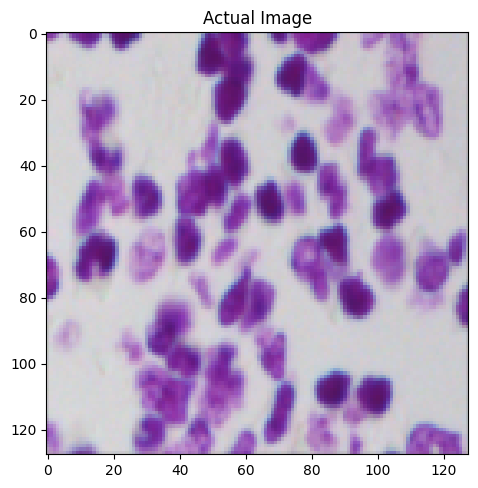

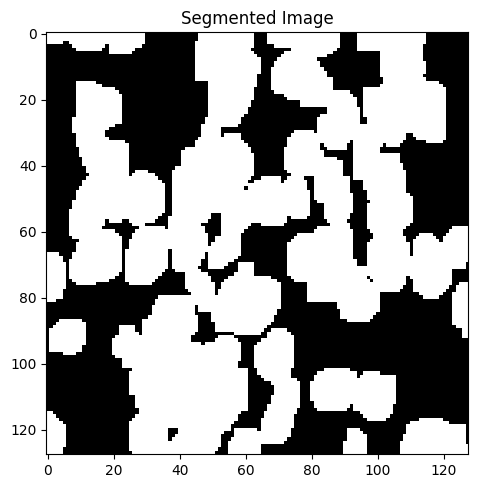

In [33]:
plot_samples(X_train,Y_train,2)

# Build the U-Net Model

U-Net is used for image segmentation and was introduced for medical imaging. 
The architecture of the model is simple: A convolutionnal encoder and a decoder connected together with skip funcions.

We will define functions that will build the down path and upsampling path.
Finally we will build a function that builds and compiles the model

In [32]:
def build_down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1,pooling=True,initializer='he_normal'):
    
    c = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=initializer,strides=strides, activation="relu")(x)
    c = Dropout(0.1)(c)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides,kernel_initializer=initializer, activation="relu")(c)
    p = MaxPooling2D((2, 2), (2, 2))(c)
    
    return c, p

In [53]:
def build_up_block(x,skip,filters, kernel_size=(3, 3), padding="same", strides=1,pooling=True,initializer='he_normal'):
    
    us = UpSampling2D((2, 2))(x)
    concat = tf.keras.layers.concatenate([us, skip])
    c = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=initializer,strides=strides, activation="relu")(concat)
    c = Dropout(0.3)(c)
    c = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=initializer,strides=strides, activation="relu")(c)
    
    return c

In [54]:
def build_bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1,initializer='he_normal'):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, kernel_initializer=initializer, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, kernel_initializer=initializer, strides=strides, activation="relu")(c)
    return c

In [60]:
def build_UNet():
    f = [16, 32, 64, 128, 256]
    inputs = Input((img_height, img_width, img_channels))
    s = Lambda(lambda x: x / 255)(inputs)

    p0 = s
    c1, p1 = build_down_block(p0, f[0]) #16
    c2, p2 = build_down_block(p1, f[1]) #32
    c3, p3 = build_down_block(p2, f[2]) #64
    c4, p4 = build_down_block(p3, f[3]) #128

    c5 = build_bottleneck(p4, f[4]) #256
    
    u6 = build_up_block(c5, c4, f[3]) #128
    u7 = build_up_block(u6, c3, f[2]) #64
    u8 = build_up_block(u7, c2, f[1]) #32
    u9 = build_up_block(u8, c1, f[0]) #16
    
    outputs = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u9)
    model = tf.keras.models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [61]:
model1=build_UNet()

In [62]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_13 (Lambda)             (None, 128, 128, 3)  0           ['input_14[0][0]']               
                                                                                                  
 conv2d_127 (Conv2D)            (None, 128, 128, 16  448         ['lambda_13[0][0]']              
                                )                                                                 
                                                                                            

In [63]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')]

history1 = model1.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
38/38 [==============================] - 101s 3s/step - loss: 0.6124 - accuracy: 0.7445 - val_loss: 0.4493 - val_accuracy: 0.7757
Epoch 2/25
38/38 [==============================] - 99s 3s/step - loss: 0.3228 - accuracy: 0.8267 - val_loss: 0.2355 - val_accuracy: 0.9142
Epoch 3/25
38/38 [==============================] - 104s 3s/step - loss: 0.1953 - accuracy: 0.9294 - val_loss: 0.1497 - val_accuracy: 0.9396
Epoch 4/25
38/38 [==============================] - 99s 3s/step - loss: 0.1473 - accuracy: 0.9452 - val_loss: 0.1415 - val_accuracy: 0.9438
Epoch 5/25
38/38 [==============================] - 99s 3s/step - loss: 0.1284 - accuracy: 0.9520 - val_loss: 0.1310 - val_accuracy: 0.9523
Epoch 6/25
38/38 [==============================] - 100s 3s/step - loss: 0.1304 - accuracy: 0.9514 - val_loss: 0.1317 - val_accuracy: 0.9502
Epoch 7/25
38/38 [==============================] - 112s 3s/step - loss: 0.1179 - accuracy: 0.9556 - val_loss: 0.1038 - val_accuracy: 0.9595
Epoch 8/25
38/38

# Visualize Model Accuracy and Loss

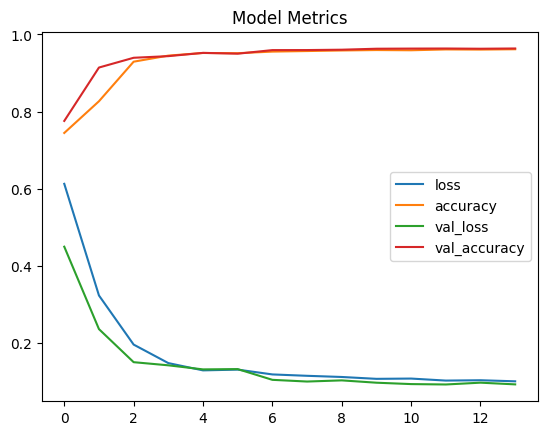

In [67]:
pd.DataFrame(history1.history).plot()
plt.title('Model Metrics')
plt.show()

# Some Predictions on the Test Set

In [69]:
predictions=model1.predict(X_test)

3/3 [==============================] - 3s 524ms/step


In [84]:
#define a threshold and compute an array of zeros and ones that indicate the presence of a cell 
pred_threshold=0.7
preds = (predictions > pred_threshold).astype(np.uint8)

In [85]:
preds

array([[[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]],


       [[[1],
         [1],
         [1],
         ...,
         [1],
         [0],
         [0]],

        [[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [0]],

        [[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [0]],

        ...,

        [[1],
         [1],
         [1],
         ...,
         [0],


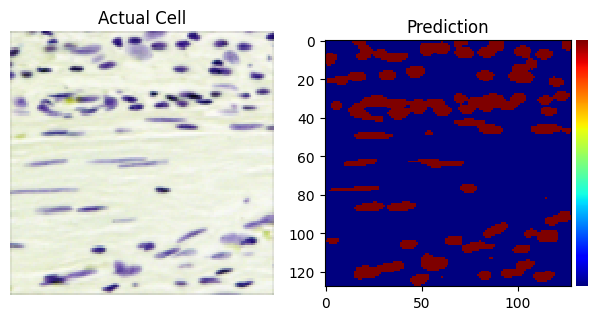

In [99]:
#visualize a sample of the prediction
index = random.randint(0, len(preds))

plt.subplot(1, 2, 1)
plt.title('Actual Cell')
imshow(X_test[index])
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Prediction')
imshow(preds[index],cmap=matplotlib.cm.jet)
plt.axis('off')
plt.show()